In [20]:
import pandas as pd

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

customers.head(), transactions.head(), products.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

In [16]:
# Merging datasets
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")

full_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

full_data.head()



,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


In [21]:
# setting date time frmats
full_data['TransactionDate'] = pd.to_datetime(full_data['TransactionDate'])

#combining all the customer data
customer_features = full_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',            
    'TransactionID': 'count',          
    'Category': pd.Series.nunique,     
    'Quantity': 'sum',               
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Category': 'CategoryDiversity',
    'Quantity': 'TotalQuantity'
}).reset_index()

customer_profiles = customers[['CustomerID', 'Region']]
customer_features = pd.merge(customer_features, customer_profiles, on='CustomerID', how='left')

customer_features.head()


,CustomerID,TotalSpending,TransactionCount,CategoryDiversity,TotalQuantity,Region
0,C0001,3354.52,5,3,12,South America
1,C0002,1862.74,4,2,10,Asia
2,C0003,2725.38,4,3,14,South America
3,C0004,5354.88,8,3,23,South America
4,C0005,2034.24,3,2,7,Asia


In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# features for clustering
numeric_features = ['TotalSpending', 'TransactionCount', 'CategoryDiversity', 'TotalQuantity']
categorical_features = ['Region']

# encoding
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

processed_features = preprocessor.fit_transform(customer_features)

# converting to pandas
processed_columns = (
    numeric_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
processed_df = pd.DataFrame(processed_features, columns=processed_columns)

processed_df.head()


,TotalSpending,TransactionCount,CategoryDiversity,TotalQuantity,Region_Asia,Region_Europe,Region_North America,Region_South America
0,-0.061701,-0.011458,0.160540,-0.122033,0.0,0.0,0.0,1.0
1,-0.877744,-0.467494,-0.904377,-0.448000,1.0,0.0,0.0,0.0
2,-0.405857,-0.467494,0.160540,0.203934,0.0,0.0,0.0,1.0
3,1.032547,1.356650,0.160540,1.670787,0.0,0.0,0.0,1.0
4,-0.783929,-0.923530,-0.904377,-0.936951,1.0,0.0,0.0,0.0


Matplotlib is building the font cache; this may take a moment.


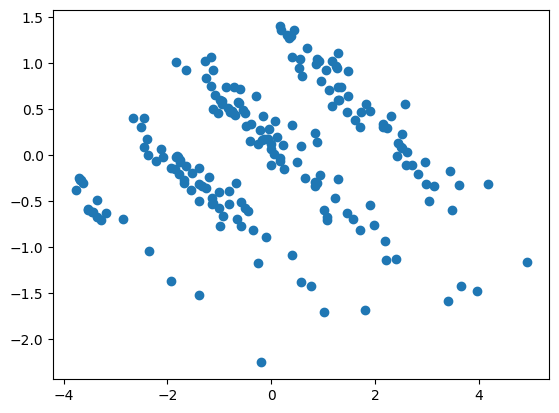

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#taking 2 most interrelated columns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_features)
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]


plt.scatter(customer_features['PCA1'],customer_features['PCA2'])

relevent_data=customer_features[['PCA1','PCA2']]
X=relevent_data






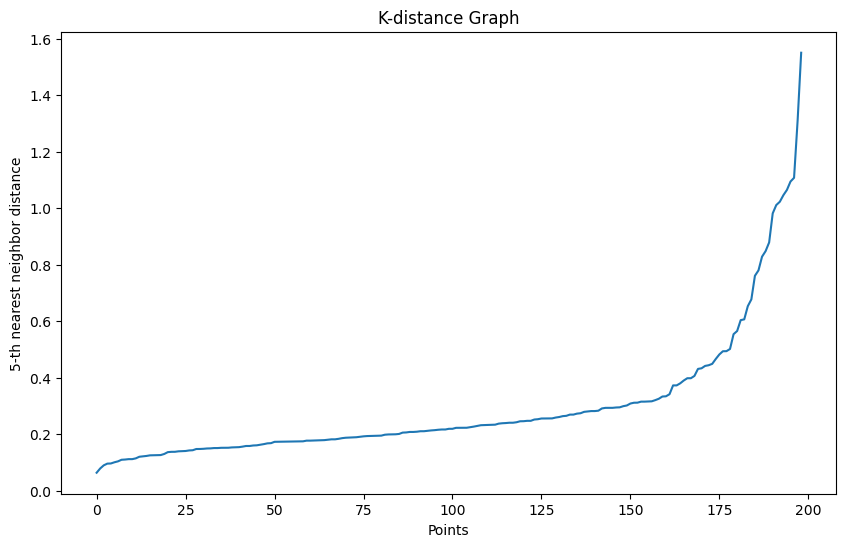

In [23]:
#creating a function to visulalise  k nearest neighbord for parameters like epsilon which we will pass to our dbscan
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(X, k=5)


In [80]:
# DBSCAN clustering
epsilon = 0.38  #as per graphs minimum
min_samples = 6
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

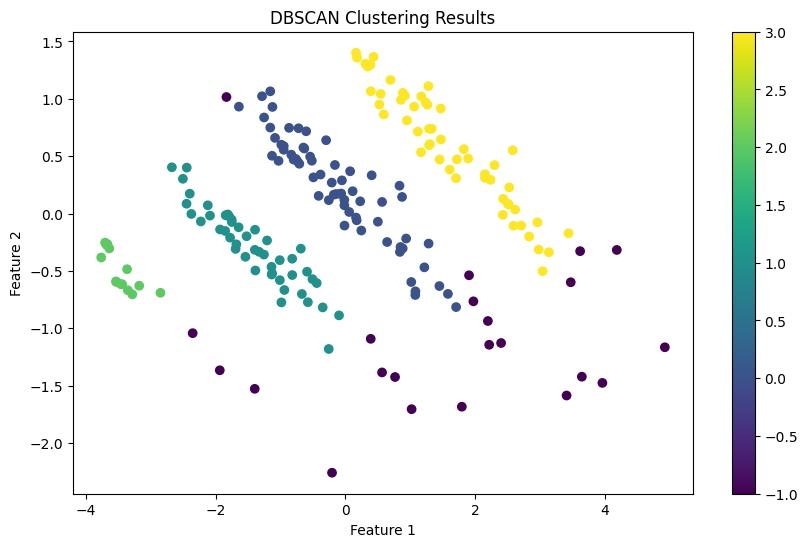

In [81]:
#cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['PCA1'], X['PCA2'], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



In [82]:
#ds score
from sklearn.metrics import davies_bouldin_score
ds=davies_bouldin_score(X,clusters)
ds

np.float64(1.197866734271172)